# 太陽光発電規制条例の分類分析

## 分析の目的

本ノートブックでは、太陽光発電規制条例のテキスト分析データ(v1.1)を用いて、以下の観点から自治体の条例を分類します:

1. **許可制 vs 届出制の判定**: 行政の関与度による分類
2. **区域設定の類型化**: 禁止地区制・抑制地区制・2層構造の判定
3. **条例の厳格度評価**: モーダル表現による規制強度の測定
4. **手続き・住民参加の重視度**: プロセス重視型かどうかの判定

## データの読み込みと確認

In [4]:
import pandas as pd

df = pd.read_csv('/home/ubuntu/cur/isep/result2.2.csv')
df.head()

,Unnamed: 0,municiparity_name,*CLAUSE_EXPLANATION,*CLAUSE_EXPLANATION_ratio(%),*CLAUSE_POSITIVE_PERMISSION_CONSENT,*CLAUSE_POSITIVE_PERMISSION_CONSENT_ratio(%),*CLAUSE_PENALTY_Lv2,*CLAUSE_PENALTY_Lv2_ratio(%),*CLAUSE_PENALTY_Lv1,*CLAUSE_PENALTY_Lv1_ratio(%),...,*PROCEDURE_NOTICE_OPERATOR_ratio(%),*PROCEDURE_TIMING,*PROCEDURE_TIMING_ratio(%),*STAKEHOLDER_RESIDENTS,*STAKEHOLDER_RESIDENTS_ratio(%),*CLAUSE_STAKEHOLDER_CONFIRMATION,*CLAUSE_STAKEHOLDER_CONFIRMATION_ratio(%),*GEO_REFERENCES,*GEO_REFERENCES_ratio(%),ケース数
0,0,かつらぎ町,0.0,0.00,0,0.00,0,0.0,12.0,12.24,...,26.53,6,6.12,10,10.20,0,0.00,0,0.00,98
1,1,伊達市,8.0,6.20,7,5.43,0,0.0,11.0,8.53,...,32.56,3,2.33,11,8.53,1,0.78,0,0.00,129
2,2,宇都宮市,11.0,5.14,8,3.74,0,0.0,11.0,5.14,...,21.03,12,5.61,15,7.01,3,1.40,5,2.34,214
3,3,皆野町,11.0,5.95,4,2.16,0,0.0,20.0,10.81,...,25.95,8,4.32,14,7.57,2,1.08,0,0.00,185
4,4,角田市,7.0,6.14,5,4.39,0,0.0,10.0,8.77,...,20.18,3,2.63,14,12.28,1,0.88,2,1.75,114


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['M+ 1c']  # 適宜インストールされている日本語フォントに変更してください
plt.rcParams['axes.unicode_minus'] = False

# データの基本情報
print("データの形状:", df.shape)
print("\n自治体数:", len(df) - 2)  # 合計行とカイ2乗値行を除く
print("\n列名一覧:")
print(df.columns.tolist())

データの形状: (55, 53)

自治体数: 53

列名一覧:
['Unnamed: 0', 'municiparity_name', '*CLAUSE_EXPLANATION', '*CLAUSE_EXPLANATION_ratio(%)', '*CLAUSE_POSITIVE_PERMISSION_CONSENT', '*CLAUSE_POSITIVE_PERMISSION_CONSENT_ratio(%)', '*CLAUSE_PENALTY_Lv2', '*CLAUSE_PENALTY_Lv2_ratio(%)', '*CLAUSE_PENALTY_Lv1', '*CLAUSE_PENALTY_Lv1_ratio(%)', '*CLAUSE_RESTRICTED_ZONE', '*CLAUSE_RESTRICTED_ZONE_ratio(%)', '*CLAUSE_ZONE_Lv1', '*CLAUSE_ZONE_Lv1_ratio(%)', '*CLAUSE_ZONE_Lv2', '*CLAUSE_ZONE_Lv2_ratio(%)', '*CLAUSE_ENVIRONMENT', '*CLAUSE_ENVIRONMENT_ratio(%)', '*CLAUSE_DOC_REQUIREMENTS', '*CLAUSE_DOC_REQUIREMENTS_ratio(%)', '*CLAUSE_DECOMMISSION_MAINTENANCE', '*CLAUSE_DECOMMISSION_MAINTENANCE_ratio(%)', '*CLAUSE_SIGNAGE', '*CLAUSE_SIGNAGE_ratio(%)', '*CLAUSE_PUBLICITY', '*CLAUSE_PUBLICITY_ratio(%)', '*CLAUSE_HEARING', '*CLAUSE_HEARING_ratio(%)', '*CLAUSE_FINANCE', '*CLAUSE_FINANCE_ratio(%)', '*CLAUSE_EQUIPMENT_NOISE', '*CLAUSE_EQUIPMENT_NOISE_ratio(%)', '*MODAL_PROHIBIT', '*MODAL_PROHIBIT_ratio(%)', '*MODAL_MUST',

## 1. データの前処理

合計行とカイ2乗値行を除外し、分析用のデータフレームを作成します。

In [33]:
# 合計行とカイ2乗値行を除外(最後の2行)
df_analysis = df.iloc[:-2].copy()

# 自治体名を確認
print("分析対象自治体:")
print(df_analysis['Municiparity_name'].tolist())

# 主要な指標列を抽出(カウント値とPearson残差)
main_columns = [
    'Municiparity_name',
    '*CLAUSE_POSITIVE_PERMISSION_CONSENT',  # 許可制
    '*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid',  # 許可制のPearson残差
    '*PROCEDURE_NOTICE_OPERATOR',  # 届出制
    '*PROCEDURE_NOTICE_OPERATOR_pearson_resid',  # 届出制のPearson残差
    '*CLAUSE_ZONE_Lv1',  # 抑制区域
    '*CLAUSE_ZONE_Lv1_pearson_resid',  # 抑制区域のPearson残差
    '*CLAUSE_ZONE_Lv2',  # 禁止区域
    '*CLAUSE_ZONE_Lv2_pearson_resid',  # 禁止区域のPearson残差
    '*CLAUSE_RESTRICTED_ZONE',  # 法定規制区域
    '*MODAL_PROHIBIT',  # 禁止表現
    '*MODAL_MUST',  # 強い義務
    '*MODAL_SHOULD',  # 努力義務
    '*CLAUSE_EXPLANATION',  # 説明会
    '*CLAUSE_HEARING',  # 意見聴取
    '*STAKEHOLDER_RESIDENTS',  # 住民関与
    '*PROCEDURE_CONSULTAION',  # 協議
    '*PROCEDURE_NOTICE_MUNICIPARITY',  # 行政通知
    'ケース数'
]

df_main = df_analysis[main_columns].copy()

# 数値列を数値型に変換(自治体名以外)
numeric_columns = [col for col in main_columns if col != 'Municiparity_name']
for col in numeric_columns:
    df_main[col] = pd.to_numeric(df_main[col], errors='coerce').fillna(0)

# カウント列は整数型に
count_columns = [col for col in numeric_columns if '_pearson_resid' not in col]
for col in count_columns:
    df_main[col] = df_main[col].astype(int)

print("データ型の確認:")
print(df_main.dtypes)
print("\n")
df_main.head()

分析対象自治体:
['宇都宮市', '玉川村', '釧路市', '松江市', '大空町', '田川市', '田村市', '登別市', '砥部町', '東広島市', '苫小牧市', '那珂市', '南砺市', '飯塚市', '福島市', '野木町', '矢祭町', '羅臼町']
データ型の確認:
Municiparity_name                                     object
*CLAUSE_POSITIVE_PERMISSION_CONSENT                    int64
*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid    float64
*PROCEDURE_NOTICE_OPERATOR                             int64
*PROCEDURE_NOTICE_OPERATOR_pearson_resid             float64
*CLAUSE_ZONE_Lv1                                       int64
*CLAUSE_ZONE_Lv1_pearson_resid                       float64
*CLAUSE_ZONE_Lv2                                       int64
*CLAUSE_ZONE_Lv2_pearson_resid                       float64
*CLAUSE_RESTRICTED_ZONE                                int64
*MODAL_PROHIBIT                                        int64
*MODAL_MUST                                            int64
*MODAL_SHOULD                                          int64
*CLAUSE_EXPLANATION                                    int6

,Municiparity_name,*CLAUSE_POSITIVE_PERMISSION_CONSENT,*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid,*PROCEDURE_NOTICE_OPERATOR,*PROCEDURE_NOTICE_OPERATOR_pearson_resid,*CLAUSE_ZONE_Lv1,*CLAUSE_ZONE_Lv1_pearson_resid,*CLAUSE_ZONE_Lv2,*CLAUSE_ZONE_Lv2_pearson_resid,*CLAUSE_RESTRICTED_ZONE,*MODAL_PROHIBIT,*MODAL_MUST,*MODAL_SHOULD,*CLAUSE_EXPLANATION,*CLAUSE_HEARING,*STAKEHOLDER_RESIDENTS,*PROCEDURE_CONSULTAION,*PROCEDURE_NOTICE_MUNICIPARITY,ケース数
0,宇都宮市,54,2.912840,47,-1.846012,12,1.368027,0,-1.806421,6,4,17,4,5,0,19,18,14,424
1,玉川村,9,-4.543681,38,-2.993895,5,-1.090724,0,-1.806421,0,1,7,8,7,0,2,1,7,165
2,釧路市,32,-0.732571,31,-3.886694,7,-0.388224,4,0.407902,0,3,9,3,4,0,8,6,8,248
3,松江市,39,0.427333,45,-2.101097,1,-2.495724,4,0.407902,3,3,18,10,13,0,17,9,8,349
4,大空町,0,-6.034986,33,-3.631609,6,-0.739474,0,-1.806421,1,0,9,4,8,0,0,7,9,171


## 2. 許可制 vs 届出制の判定

`CLAUSE_POSITIVE_PERMISSION_CONSENT`(許可・承認)と`PROCEDURE_NOTICE_OPERATOR`(届出)の出現頻度とPearson残差を組み合わせて、各自治体の規制タイプを判定します。

**判定基準:**
- **Pearson残差を考慮**: 残差が正(+1.0以上)の場合、その条項が自治体で特徴的に重視されていると判断
- **許可制優位**: 
  - 許可のPearson残差 > 1.0、または
  - 許可 > 0 かつ (届出 = 0 または 許可/届出 ≥ 0.5)
- **届出制優位**: 
  - 届出のPearson残差 > 1.0 かつ 許可のPearson残差 < 1.0、または
  - 許可 = 0 かつ 届出 > 0
- **混合型**: 上記以外

In [34]:
def classify_regulation_type(row):
    """許可制・届出制の分類関数
    
    法律文書では「許可」という文言は慎重に使用されるため、
    出現回数とPearson残差を組み合わせて判定する。
    """
    permission = row['*CLAUSE_POSITIVE_PERMISSION_CONSENT']
    notice = row['*PROCEDURE_NOTICE_OPERATOR']
    permission_resid = row['*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid']
    notice_resid = row['*PROCEDURE_NOTICE_OPERATOR_pearson_resid']
    
    # 両方とも0の場合
    if notice == 0 and permission == 0:
        return '規定なし'
    
    # Pearson残差が大きい(+1.0以上)場合、その条項が特徴的に重視されている
    # 許可のPearson残差が顕著に正の場合、許可制優位
    if permission_resid > 1.0:
        return '許可制優位'
    
    # 届出のPearson残差が顕著に正で、許可が特徴的でない場合、届出制優位
    if notice_resid > 1.0 and permission_resid < 1.0:
        return '届出制優位'
    
    # Pearson残差が決定的でない場合、カウント数で判定
    if permission > 0:
        if notice == 0:
            return '許可制優位'
        ratio = permission / notice
        # 許可が届出の半分以上あれば、許可制の意図があると判断
        if ratio >= 0.5:
            return '許可制優位'
        else:
            return '混合型'
    else:
        # 許可が0で届出のみの場合
        return '届出制優位'

# 分類の適用
df_main['規制タイプ'] = df_main.apply(classify_regulation_type, axis=1)

# 結果の表示
regulation_summary = df_main[['Municiparity_name', 
                                '*CLAUSE_POSITIVE_PERMISSION_CONSENT',
                                '*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid',
                                '*PROCEDURE_NOTICE_OPERATOR',
                                '*PROCEDURE_NOTICE_OPERATOR_pearson_resid',
                                '規制タイプ']].copy()
regulation_summary.columns = ['自治体', '許可関連', '許可(残差)', '届出関連', '届出(残差)', '規制タイプ']
# 残差を小数点第2位まで表示
regulation_summary['許可(残差)'] = regulation_summary['許可(残差)'].round(2)
regulation_summary['届出(残差)'] = regulation_summary['届出(残差)'].round(2)
print(regulation_summary.to_string(index=False))

print("\n\n規制タイプの分布:")
print(df_main['規制タイプ'].value_counts())

 自治体  許可関連  許可(残差)  届出関連  届出(残差) 規制タイプ
宇都宮市    54    2.91    47   -1.85 許可制優位
 玉川村     9   -4.54    38   -2.99   混合型
 釧路市    32   -0.73    31   -3.89 許可制優位
 松江市    39    0.43    45   -2.10 許可制優位
 大空町     0   -6.03    33   -3.63 届出制優位
 田川市     0   -6.03    11   -6.44 届出制優位
 田村市     4   -5.37    22   -5.03   混合型
 登別市     1   -5.87    39   -2.87   混合型
 砥部町    41    0.76    21   -5.16 許可制優位
東広島市     2   -5.70    32   -3.76   混合型
苫小牧市     0   -6.03    42   -2.48 届出制優位
 那珂市     7   -4.88    30   -4.01   混合型
 南砺市    67    5.07    27   -4.40 許可制優位
 飯塚市     0   -6.03    40   -2.74 届出制優位
 福島市    30   -1.06    36   -3.25 許可制優位
 野木町     0   -6.03    48   -1.72 届出制優位
 矢祭町    59    3.74    21   -5.16 許可制優位
 羅臼町     1   -5.87    21   -5.16   混合型


規制タイプの分布:
規制タイプ
許可制優位    7
混合型      6
届出制優位    5
Name: count, dtype: int64


## 3. 区域設定の類型化

`CLAUSE_ZONE_Lv1`(抑制区域)と`CLAUSE_ZONE_Lv2`(禁止区域)の設定状況とPearson残差を組み合わせて、区域規制の類型を判定します。

**判定基準:**
- **Pearson残差を考慮**: 残差が正(+1.0以上)の場合、その区域設定が自治体で特徴的に重視されていると判断
- **禁止地区制**: 
  - 禁止区域のPearson残差 > 1.0、または
  - Lv2 > 0 かつ Lv1 < Lv2 × 2
- **抑制地区制**: 
  - 抑制区域のPearson残差 > 1.0 かつ 禁止区域のPearson残差 < 1.0、または
  - Lv2 = 0 かつ Lv1 ≥ 3
- **2層構造**: Lv1 ≥ 3 かつ Lv2 ≥ 3

In [35]:
def classify_zone_type(row):
    """区域設定の類型化関数
    
    法律文書では「禁止」という文言は慎重に使用されるため、
    出現回数とPearson残差を組み合わせて判定する。
    """
    lv1 = row['*CLAUSE_ZONE_Lv1']  # 抑制区域
    lv2 = row['*CLAUSE_ZONE_Lv2']  # 禁止区域
    lv1_resid = row['*CLAUSE_ZONE_Lv1_pearson_resid']
    lv2_resid = row['*CLAUSE_ZONE_Lv2_pearson_resid']
    
    # 両方とも0の場合
    if lv1 == 0 and lv2 == 0:
        return '区域設定なし'
    
    # Pearson残差が大きい(+1.0以上)場合、その区域設定が特徴的に重視されている
    # 禁止区域のPearson残差が顕著に正の場合、禁止地区制
    if lv2_resid > 1.0:
        # ただし、両方が一定以上あれば2層構造
        if lv1 >= 3 and lv2 >= 3:
            return '2層構造(禁止+抑制)'
        else:
            return '禁止地区制'
    
    # 抑制区域のPearson残差が顕著に正で、禁止が特徴的でない場合、抑制地区制
    if lv1_resid > 1.0 and lv2_resid < 1.0:
        if lv2 > 0:
            return '抑制地区制(禁止区域含む)'
        else:
            return '抑制地区制'
    
    # Pearson残差が決定的でない場合、カウント数で判定
    if lv2 > 0:
        # 両方が一定以上(3以上)あれば2層構造
        if lv1 >= 3 and lv2 >= 3:
            return '2層構造(禁止+抑制)'
        # 抑制が禁止の2倍以上ある場合のみ抑制地区制
        elif lv1 >= lv2 * 2:
            return '抑制地区制(禁止区域含む)'
        else:
            return '禁止地区制'
    else:
        # 禁止区域が0で抑制区域のみの場合
        if lv1 >= 3:
            return '抑制地区制'
        else:
            return '区域設定あり(少数)'

# 分類の適用
df_main['区域類型'] = df_main.apply(classify_zone_type, axis=1)

# 結果の表示
zone_summary = df_main[['Municiparity_name', 
                         '*CLAUSE_ZONE_Lv1',
                         '*CLAUSE_ZONE_Lv1_pearson_resid',
                         '*CLAUSE_ZONE_Lv2',
                         '*CLAUSE_ZONE_Lv2_pearson_resid',
                         '*CLAUSE_RESTRICTED_ZONE',
                         '区域類型']].copy()
zone_summary.columns = ['自治体', '抑制区域(Lv1)', '抑制(残差)', '禁止区域(Lv2)', '禁止(残差)', '法定規制区域', '区域類型']
# 残差を小数点第2位まで表示
zone_summary['抑制(残差)'] = zone_summary['抑制(残差)'].round(2)
zone_summary['禁止(残差)'] = zone_summary['禁止(残差)'].round(2)
print(zone_summary.to_string(index=False))

print("\n\n区域類型の分布:")
print(df_main['区域類型'].value_counts())

 自治体  抑制区域(Lv1)  抑制(残差)  禁止区域(Lv2)  禁止(残差)  法定規制区域          区域類型
宇都宮市         12    1.37          0   -1.81       6         抑制地区制
 玉川村          5   -1.09          0   -1.81       0         抑制地区制
 釧路市          7   -0.39          4    0.41       0   2層構造(禁止+抑制)
 松江市          1   -2.50          4    0.41       3         禁止地区制
 大空町          6   -0.74          0   -1.81       1         抑制地区制
 田川市          6   -0.74          0   -1.81       0         抑制地区制
 田村市          7   -0.39          1   -1.25       3 抑制地区制(禁止区域含む)
 登別市          8   -0.04          4    0.41       3   2層構造(禁止+抑制)
 砥部町          0   -2.85          1   -1.25       0         禁止地区制
東広島市          4   -1.44          0   -1.81       0         抑制地区制
苫小牧市          1   -2.50          5    0.96       0         禁止地区制
 那珂市          4   -1.44          0   -1.81       0         抑制地区制
 南砺市          0   -2.85          3   -0.15       3         禁止地区制
 飯塚市          4   -1.44          4    0.41       3   2層構造(禁止+抑制)
 福島市          0   -2.85  

## 4. 条例の厳格度評価

モーダル表現(`MODAL_PROHIBIT`, `MODAL_MUST`, `MODAL_SHOULD`)から、条例の規制強度を評価します。

**厳格度スコア = 禁止表現 + 強い義務表現 - 努力義務表現**

スコアが高いほど厳格な条例と判断します。

In [36]:
# 厳格度スコアの計算
df_main['厳格度スコア'] = (df_main['*MODAL_PROHIBIT'] + 
                           df_main['*MODAL_MUST'] - 
                           df_main['*MODAL_SHOULD'])

# ケース数あたりに正規化
df_main['厳格度スコア(正規化)'] = df_main['厳格度スコア'] / df_main['ケース数'] * 100

# 厳格度レベルの分類
def classify_strictness(score_normalized):
    if score_normalized >= 5:
        return '非常に厳格'
    elif score_normalized >= 2:
        return '厳格'
    elif score_normalized >= 0:
        return '標準'
    else:
        return '緩やか'

df_main['厳格度レベル'] = df_main['厳格度スコア(正規化)'].apply(classify_strictness)

# 結果の表示
strictness_summary = df_main[['Municiparity_name', 
                               '*MODAL_PROHIBIT', 
                               '*MODAL_MUST', 
                               '*MODAL_SHOULD',
                               '厳格度スコア',
                               '厳格度スコア(正規化)',
                               '厳格度レベル']].copy()
strictness_summary.columns = ['自治体', '禁止', '義務', '努力義務', 'スコア', 'スコア(正規化)', 'レベル']
strictness_summary_sorted = strictness_summary.sort_values('スコア(正規化)', ascending=False)
print(strictness_summary_sorted.to_string(index=False))

print("\n\n厳格度レベルの分布:")
print(df_main['厳格度レベル'].value_counts())

 自治体  禁止  義務  努力義務  スコア  スコア(正規化)   レベル
 那珂市   1  17     2   16 10.000000 非常に厳格
 砥部町   4  23     4   23  8.550186 非常に厳格
 飯塚市   2  12     5    9  4.945055    厳格
 登別市   3  12     3   12  4.918033    厳格
 田村市   2  12     4   10  4.878049    厳格
宇都宮市   4  17     4   17  4.009434    厳格
 矢祭町   4  10     1   13  3.631285    厳格
 釧路市   3   9     3    9  3.629032    厳格
東広島市   2   7     5    4  3.361345    厳格
 松江市   3  18    10   11  3.151862    厳格
 田川市   0   6     3    3  3.125000    厳格
苫小牧市   3   7     4    6  3.030303    厳格
 南砺市   3  21     3   21  3.008596    厳格
 大空町   0   9     4    5  2.923977    厳格
 福島市   0   2     0    2  0.653595    標準
 野木町   1   7     7    1  0.375940    標準
 玉川村   1   7     8    0  0.000000    標準
 羅臼町   0   4     8   -4 -4.081633   緩やか


厳格度レベルの分布:
厳格度レベル
厳格       12
標準        3
非常に厳格     2
緩やか       1
Name: count, dtype: int64


## 5. 住民参加・手続き重視度の評価

住民関与や手続きに関する条項から、プロセス重視型かどうかを評価します。

**住民参加スコア = 説明会 + 意見聴取 + 住民関与**  
**手続きスコア = 協議 + 行政通知 + 届出**

In [37]:
# 住民参加スコアの計算
df_main['住民参加スコア'] = (df_main['*CLAUSE_EXPLANATION'] + 
                            df_main['*CLAUSE_HEARING'] + 
                            df_main['*STAKEHOLDER_RESIDENTS'])

# 手続きスコアの計算
df_main['手続きスコア'] = (df_main['*PROCEDURE_CONSULTAION'] + 
                          df_main['*PROCEDURE_NOTICE_MUNICIPARITY'] + 
                          df_main['*PROCEDURE_NOTICE_OPERATOR'])

# 正規化
df_main['住民参加スコア(正規化)'] = df_main['住民参加スコア'] / df_main['ケース数'] * 100
df_main['手続きスコア(正規化)'] = df_main['手続きスコア'] / df_main['ケース数'] * 100

# プロセス重視度の分類
def classify_process_orientation(row):
    resident = row['住民参加スコア(正規化)']
    procedure = row['手続きスコア(正規化)']
    
    if resident >= 10 and procedure >= 15:
        return '住民参加・手続き重視型'
    elif resident >= 10:
        return '住民参加重視型'
    elif procedure >= 15:
        return '手続き重視型'
    else:
        return '標準型'

df_main['プロセス重視度'] = df_main.apply(classify_process_orientation, axis=1)

# 結果の表示
process_summary = df_main[['Municiparity_name',
                           '住民参加スコア',
                           '住民参加スコア(正規化)',
                           '手続きスコア',
                           '手続きスコア(正規化)',
                           'プロセス重視度']].copy()
process_summary.columns = ['自治体', '住民参加', '住民参加(正規化)', '手続き', '手続き(正規化)', 'プロセス重視度']
process_summary_sorted = process_summary.sort_values('住民参加(正規化)', ascending=False)
print(process_summary_sorted.to_string(index=False))

print("\n\nプロセス重視度の分布:")
print(df_main['プロセス重視度'].value_counts())

 自治体  住民参加  住民参加(正規化)  手続き  手続き(正規化)     プロセス重視度
 砥部町    34  12.639405   70 26.022305 住民参加・手続き重視型
 田村市    18   8.780488   35 17.073171      手続き重視型
 松江市    30   8.595989   62 17.765043      手続き重視型
東広島市    10   8.403361   47 39.495798      手続き重視型
 登別市    20   8.196721   54 22.131148      手続き重視型
 羅臼町     6   6.122449   22 22.448980      手続き重視型
 南砺市    41   5.873926   66  9.455587         標準型
宇都宮市    24   5.660377   79 18.632075      手続き重視型
 玉川村     9   5.454545   46 27.878788      手続き重視型
 矢祭町    19   5.307263   58 16.201117      手続き重視型
 釧路市    12   4.838710   45 18.145161      手続き重視型
 大空町     8   4.678363   49 28.654971      手続き重視型
苫小牧市     9   4.545455   58 29.292929      手続き重視型
 那珂市     7   4.375000   57 35.625000      手続き重視型
 福島市    13   4.248366   50 16.339869      手続き重視型
 飯塚市     6   3.296703   49 26.923077      手続き重視型
 野木町     7   2.631579   86 32.330827      手続き重視型
 田川市     0   0.000000   20 20.833333      手続き重視型


プロセス重視度の分布:
プロセス重視度
手続き重視型         16
住民参加・手続き重視型     1
標準型        

## 6. 総合的な分類結果の統合

これまでの4つの観点を統合し、各自治体の条例特性を一覧表示します。

In [38]:
# 確認: df_mainに必要な列が全て存在するかチェック
required_columns = ['規制タイプ', '区域類型', '厳格度レベル', 'プロセス重視度', 
                    '厳格度スコア(正規化)', '住民参加スコア(正規化)', '手続きスコア(正規化)']

print("df_mainの列一覧:")
print(df_main.columns.tolist())
print("\n必要な列の存在確認:")
for col in required_columns:
    if col in df_main.columns:
        print(f"✓ {col}: 存在")
    else:
        print(f"✗ {col}: 存在しない")

df_mainの列一覧:
['Municiparity_name', '*CLAUSE_POSITIVE_PERMISSION_CONSENT', '*CLAUSE_POSITIVE_PERMISSION_CONSENT_pearson_resid', '*PROCEDURE_NOTICE_OPERATOR', '*PROCEDURE_NOTICE_OPERATOR_pearson_resid', '*CLAUSE_ZONE_Lv1', '*CLAUSE_ZONE_Lv1_pearson_resid', '*CLAUSE_ZONE_Lv2', '*CLAUSE_ZONE_Lv2_pearson_resid', '*CLAUSE_RESTRICTED_ZONE', '*MODAL_PROHIBIT', '*MODAL_MUST', '*MODAL_SHOULD', '*CLAUSE_EXPLANATION', '*CLAUSE_HEARING', '*STAKEHOLDER_RESIDENTS', '*PROCEDURE_CONSULTAION', '*PROCEDURE_NOTICE_MUNICIPARITY', 'ケース数', '規制タイプ', '区域類型', '厳格度スコア', '厳格度スコア(正規化)', '厳格度レベル', '住民参加スコア', '手続きスコア', '住民参加スコア(正規化)', '手続きスコア(正規化)', 'プロセス重視度']

必要な列の存在確認:
✓ 規制タイプ: 存在
✓ 区域類型: 存在
✓ 厳格度レベル: 存在
✓ プロセス重視度: 存在
✓ 厳格度スコア(正規化): 存在
✓ 住民参加スコア(正規化): 存在
✓ 手続きスコア(正規化): 存在


In [39]:
# 総合結果の統合
comprehensive_result = df_main[['Municiparity_name',
                                 'ケース数',
                                 '規制タイプ',
                                 '区域類型',
                                 '厳格度レベル',
                                 'プロセス重視度',
                                 '厳格度スコア(正規化)',
                                 '住民参加スコア(正規化)',
                                 '手続きスコア(正規化)']].copy()

comprehensive_result.columns = ['自治体', 'ケース数', '規制タイプ', '区域類型', 
                                '厳格度', 'プロセス重視度', '厳格度(正規化)', 
                                '住民参加(正規化)', '手続き(正規化)']

# 数値を小数点第1位まで表示
for col in ['厳格度(正規化)', '住民参加(正規化)', '手続き(正規化)']:
    comprehensive_result[col] = comprehensive_result[col].round(1)

print("=" * 150)
print("太陽光発電規制条例の総合分類結果")
print("=" * 150)
print(comprehensive_result.to_string(index=False))

# 分類結果をCSVで保存
output_file = '/home/ubuntu/cur/isep/result_solar_rule_classification.csv'
comprehensive_result.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"\n\n分類結果を保存しました: {output_file}")

太陽光発電規制条例の総合分類結果
 自治体  ケース数 規制タイプ          区域類型   厳格度     プロセス重視度  厳格度(正規化)  住民参加(正規化)  手続き(正規化)
宇都宮市   424 許可制優位         抑制地区制    厳格      手続き重視型       4.0        5.7      18.6
 玉川村   165   混合型         抑制地区制    標準      手続き重視型       0.0        5.5      27.9
 釧路市   248 許可制優位   2層構造(禁止+抑制)    厳格      手続き重視型       3.6        4.8      18.1
 松江市   349 許可制優位         禁止地区制    厳格      手続き重視型       3.2        8.6      17.8
 大空町   171 届出制優位         抑制地区制    厳格      手続き重視型       2.9        4.7      28.7
 田川市    96 届出制優位         抑制地区制    厳格      手続き重視型       3.1        0.0      20.8
 田村市   205   混合型 抑制地区制(禁止区域含む)    厳格      手続き重視型       4.9        8.8      17.1
 登別市   244   混合型   2層構造(禁止+抑制)    厳格      手続き重視型       4.9        8.2      22.1
 砥部町   269 許可制優位         禁止地区制 非常に厳格 住民参加・手続き重視型       8.6       12.6      26.0
東広島市   119   混合型         抑制地区制    厳格      手続き重視型       3.4        8.4      39.5
苫小牧市   198 届出制優位         禁止地区制    厳格      手続き重視型       3.0        4.5      29.3
 那珂市   160   混合型       

## 7. 可視化: クロス集計と散布図

分類結果を可視化し、自治体間の特徴を比較します。

In [40]:
# クロス集計: 規制タイプ × 区域類型
cross_tab = pd.crosstab(df_main['規制タイプ'], df_main['区域類型'])
print("規制タイプ × 区域類型のクロス集計:")
print(cross_tab)
print("\n")

# クロス集計: 規制タイプ × 厳格度レベル
cross_tab2 = pd.crosstab(df_main['規制タイプ'], df_main['厳格度レベル'])
print("規制タイプ × 厳格度レベルのクロス集計:")
print(cross_tab2)
print("\n")

# クロス集計: 区域類型 × 厳格度レベル
cross_tab3 = pd.crosstab(df_main['区域類型'], df_main['厳格度レベル'])
print("区域類型 × 厳格度レベルのクロス集計:")
print(cross_tab3)

規制タイプ × 区域類型のクロス集計:
区域類型   2層構造(禁止+抑制)  区域設定なし  抑制地区制  抑制地区制(禁止区域含む)  禁止地区制
規制タイプ                                                  
届出制優位            1       0      3              0      1
混合型              1       1      3              1      0
許可制優位            2       0      1              0      4


規制タイプ × 厳格度レベルのクロス集計:
厳格度レベル  厳格  標準  緩やか  非常に厳格
規制タイプ                     
届出制優位    4   1    0      0
混合型      3   1    1      1
許可制優位    5   1    0      1


区域類型 × 厳格度レベルのクロス集計:
厳格度レベル         厳格  標準  緩やか  非常に厳格
区域類型                             
2層構造(禁止+抑制)     4   0    0      0
区域設定なし          0   0    1      0
抑制地区制           4   2    0      1
抑制地区制(禁止区域含む)   1   0    0      0
禁止地区制           3   1    0      1


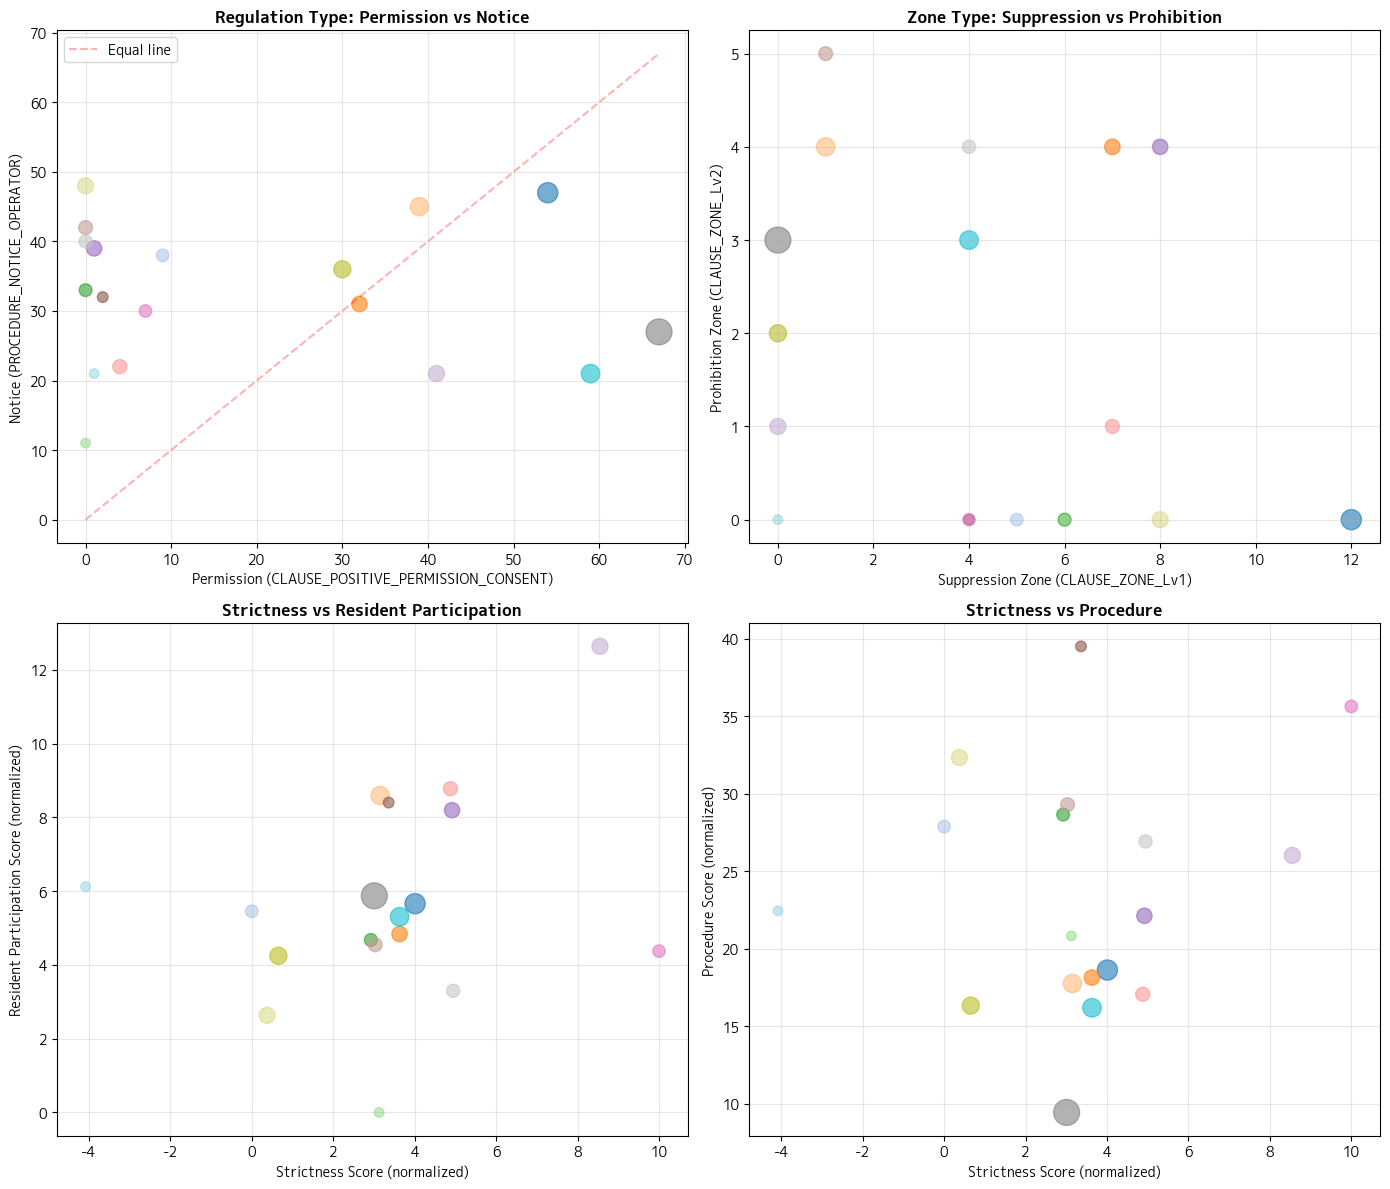

散布図を保存しました: solar_rule_classification_scatter.png


In [41]:
# 散布図: 許可 vs 届出
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. 許可 vs 届出
ax1 = axes[0, 0]
scatter1 = ax1.scatter(df_main['*CLAUSE_POSITIVE_PERMISSION_CONSENT'], 
                       df_main['*PROCEDURE_NOTICE_OPERATOR'],
                       s=df_main['ケース数']/2,
                       alpha=0.6, 
                       c=range(len(df_main)), 
                       cmap='tab20')
ax1.set_xlabel('Permission (CLAUSE_POSITIVE_PERMISSION_CONSENT)', fontsize=10)
ax1.set_ylabel('Notice (PROCEDURE_NOTICE_OPERATOR)', fontsize=10)
ax1.set_title('Regulation Type: Permission vs Notice', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
# 対角線を追加
max_val = max(df_main['*CLAUSE_POSITIVE_PERMISSION_CONSENT'].max(), 
              df_main['*PROCEDURE_NOTICE_OPERATOR'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.3, label='Equal line')
ax1.legend()

# 2. 抑制区域 vs 禁止区域
ax2 = axes[0, 1]
scatter2 = ax2.scatter(df_main['*CLAUSE_ZONE_Lv1'], 
                       df_main['*CLAUSE_ZONE_Lv2'],
                       s=df_main['ケース数']/2,
                       alpha=0.6,
                       c=range(len(df_main)),
                       cmap='tab20')
ax2.set_xlabel('Suppression Zone (CLAUSE_ZONE_Lv1)', fontsize=10)
ax2.set_ylabel('Prohibition Zone (CLAUSE_ZONE_Lv2)', fontsize=10)
ax2.set_title('Zone Type: Suppression vs Prohibition', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. 厳格度スコア vs 住民参加スコア
ax3 = axes[1, 0]
scatter3 = ax3.scatter(df_main['厳格度スコア(正規化)'], 
                       df_main['住民参加スコア(正規化)'],
                       s=df_main['ケース数']/2,
                       alpha=0.6,
                       c=range(len(df_main)),
                       cmap='tab20')
ax3.set_xlabel('Strictness Score (normalized)', fontsize=10)
ax3.set_ylabel('Resident Participation Score (normalized)', fontsize=10)
ax3.set_title('Strictness vs Resident Participation', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. 厳格度スコア vs 手続きスコア
ax4 = axes[1, 1]
scatter4 = ax4.scatter(df_main['厳格度スコア(正規化)'], 
                       df_main['手続きスコア(正規化)'],
                       s=df_main['ケース数']/2,
                       alpha=0.6,
                       c=range(len(df_main)),
                       cmap='tab20')
ax4.set_xlabel('Strictness Score (normalized)', fontsize=10)
ax4.set_ylabel('Procedure Score (normalized)', fontsize=10)
ax4.set_title('Strictness vs Procedure', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/ubuntu/cur/isep/solar_rule_classification_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("散布図を保存しました: solar_rule_classification_scatter.png")

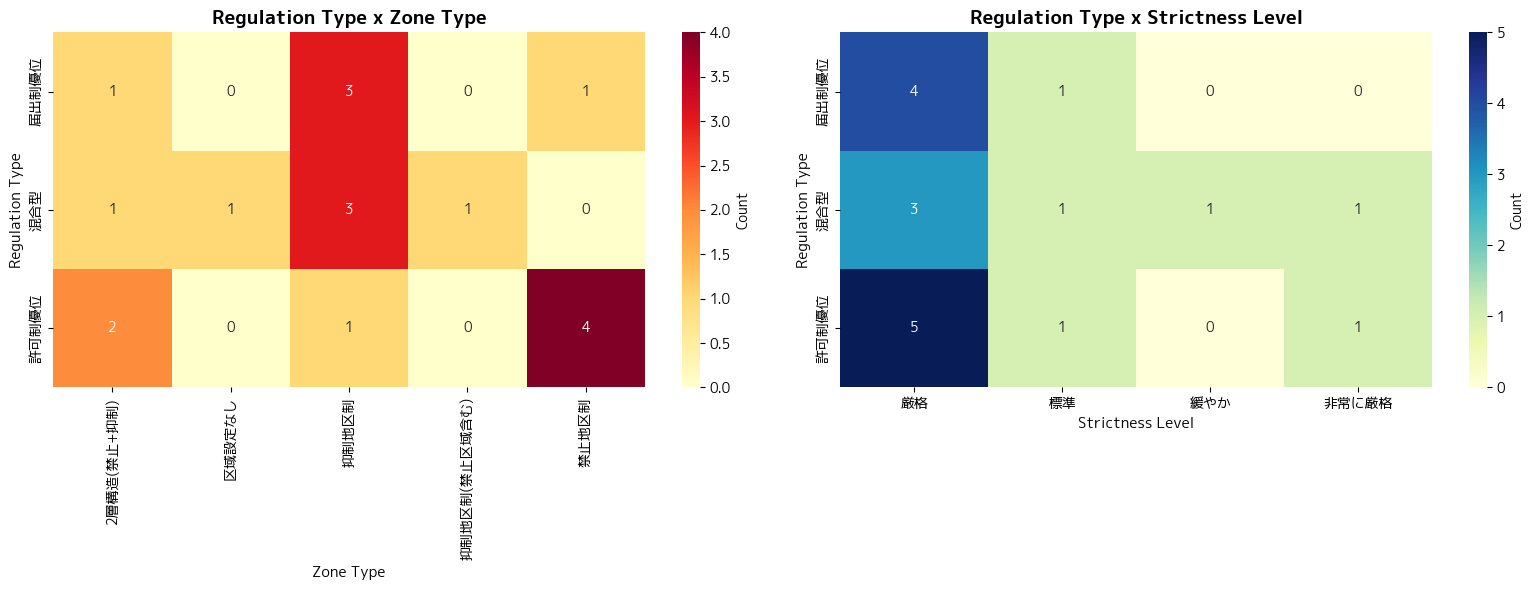

ヒートマップを保存しました: solar_rule_classification_heatmap.png


In [42]:
# ヒートマップ: 分類結果の全体像
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 規制タイプと区域類型のクロス集計をヒートマップ化
ax1 = axes[0]
cross_tab_heatmap = pd.crosstab(df_main['規制タイプ'], df_main['区域類型'])
sns.heatmap(cross_tab_heatmap, annot=True, fmt='d', cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Regulation Type x Zone Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Zone Type', fontsize=11)
ax1.set_ylabel('Regulation Type', fontsize=11)

# 規制タイプと厳格度レベルのクロス集計をヒートマップ化
ax2 = axes[1]
cross_tab_heatmap2 = pd.crosstab(df_main['規制タイプ'], df_main['厳格度レベル'])
sns.heatmap(cross_tab_heatmap2, annot=True, fmt='d', cmap='YlGnBu', ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title('Regulation Type x Strictness Level', fontsize=14, fontweight='bold')
ax2.set_xlabel('Strictness Level', fontsize=11)
ax2.set_ylabel('Regulation Type', fontsize=11)

plt.tight_layout()
plt.savefig('/home/ubuntu/cur/isep/solar_rule_classification_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("ヒートマップを保存しました: solar_rule_classification_heatmap.png")

## 8. まとめと考察

### 分析結果の要約

本分析では、18自治体の太陽光発電規制条例を以下の4つの観点から分類しました:

1. **規制タイプ**: 許可制優位・届出制優位・混合型
2. **区域類型**: 禁止地区制・抑制地区制・2層構造・区域設定なし
3. **厳格度レベル**: 非常に厳格・厳格・標準・緩やか
4. **プロセス重視度**: 住民参加重視型・手続き重視型・住民参加・手続き重視型・標準型

### 主な発見

- **規制タイプ**: 自治体によって許可制と届出制のバランスが大きく異なる
- **区域設定**: 抑制区域のみ、禁止区域のみ、両方を設定する2層構造など多様
- **厳格度**: モーダル表現の分析により、条例の規制強度に差があることが判明
- **住民参加**: 説明会や意見聴取の要求度合いは自治体ごとに異なる

### 今後の展開

- **FIT事業計画認定情報との突合**: 各自治体の太陽光発電事業件数と条例の厳格度の関係を分析
- **時系列分析**: 条例制定前後での事業展開の変化を追跡
- **地理的分析**: 地域特性(地形・土地利用など)と条例内容の関連性を検討